Training



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm

#############################
# Spectral Convolution Layer
#############################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along time dimension
        self.modes2 = modes2  # Fourier modes along space dimension
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        # Performs complex multiplication along the Fourier modes.
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

#############################
# Fourier Neural Operator Model (FNO2d)
#############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers=3):
        """
        The network takes an input of 3 channels:
         - u(t): the control function (broadcast along x)
         - t: time coordinate
         - x: spatial coordinate
        and outputs F_pred(t,x) with one channel.
        """
        super(FNO2d, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(3, width)  # lift input channels to the desired width

        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch, 3, Nt, Nx)
        batch, channels, Nt, Nx = x.shape
        # Lift input to a higher dimension
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, 3)
        x = self.fc0(x)           # (batch, Nt, Nx, width)
        x = x.permute(0, 3, 1, 2)  # (batch, width, Nt, Nx)

        # Apply Fourier layers + pointwise convolutions
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)

        # Project to the output channel
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, width)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)           # (batch, Nt, Nx, 1)
        x = x.permute(0, 3, 1, 2)  # (batch, 1, Nt, Nx)
        return x

#############################
# Updated Ground Truth Function
#############################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the recovery (hitting time) probability for:
         dx_t = u(t) dt + dW_t,
    with hitting time density
         f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t))
    and then F is obtained by cumulative integration over time.
    To avoid artifacts near the barrier at x = a, we clip the cumulative
    values to [0, 1] and force F(t,x)=1 for x sufficiently close to a.
    """
    # Compute U(t) = ∫₀ᵗ u(s) ds
    U = cumulative_trapezoid(u, T_vals, initial=0)
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2) / (2*T_grid_mod))
    # Perform the cumulative integration over time
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Clip to [0, 1] to avoid numerical overshoots
    F = np.clip(F, 0, 1)
    # Force the boundary condition: for x values sufficiently close to a, set F=1.
    tol = 1e-8
    ix = np.where(x_vals >= a - tol)[0]
    F[:, ix] = 1.0
    return F

#############################
# Finite Difference Derivatives
#############################
def compute_fd_derivatives(F, dt, dx):
    """
    Compute finite-difference approximations of the derivatives:
       F_t, F_x, and F_xx for a field F of shape (batch, 1, Nt, Nx).
    """
    batch, ch, Nt, Nx = F.shape

    # Time derivative F_t
    F_t = torch.zeros_like(F)
    F_t[:,:,1:-1,:] = (F[:,:,2:,:] - F[:,:,:-2,:]) / (2*dt)
    F_t[:,:,0,:] = (F[:,:,1,:] - F[:,:,0,:]) / dt
    F_t[:,:,-1,:] = (F[:,:,-1,:] - F[:,:,-2,:]) / dt

    # Spatial derivative F_x
    F_x = torch.zeros_like(F)
    F_x[:,:,:,1:-1] = (F[:,:,:,2:] - F[:,:,:,:-2]) / (2*dx)
    F_x[:,:,:,0] = (F[:,:,:,1] - F[:,:,:,0]) / dx
    F_x[:,:,:,-1] = (F[:,:,:,-1] - F[:,:,:,-2]) / dx

    # Second spatial derivative F_xx
    F_xx = torch.zeros_like(F)
    F_xx[:,:,:,1:-1] = (F[:,:,:,2:] - 2*F[:,:,:,1:-1] + F[:,:,:,:-2]) / (dx**2)
    F_xx[:,:,:,0] = (F[:,:,:,2] - 2*F[:,:,:,1] + F[:,:,:,0]) / (dx**2)
    F_xx[:,:,:,-1] = (F[:,:,:,-1] - 2*F[:,:,:,-2] + F[:,:,:,-3]) / (dx**2)

    return F_t, F_x, F_xx

#############################
# Setup: Grids and Data Generation
#############################
T = 10.0           # maximum time
a = 4.0            # fixed barrier
n_samples = 10     # number of training samples

# Time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)   # 1001 points
Nt = len(T_vals)
# Spatial grid
x_vals = np.linspace(-10, a, 101)       # 101 points
Nx = len(x_vals)
dt = T_vals[1] - T_vals[0]
dx = x_vals[1] - x_vals[0]

# Generate training data: each sample has a different u(t) and corresponding F_true(t,x)
training_data = []
for _ in range(n_samples):
    # With probability 0.5, use a single sine wave; otherwise, a sum of two sine waves.
    if np.random.rand() < 0.5:
        A = np.random.uniform(-1, 1)
        freq = np.random.uniform(0.5, 2)
        phi = np.random.uniform(0, 2*np.pi)
        u_np = A * np.sin(2*np.pi * freq * T_vals/T + phi)
    else:
        A1 = np.random.uniform(-1, 1)
        freq1 = np.random.uniform(0.5, 2)
        phi1 = np.random.uniform(0, 2*np.pi)
        A2 = np.random.uniform(-1, 1)
        freq2 = np.random.uniform(0.5, 2)
        phi2 = np.random.uniform(0, 2*np.pi)
        u_np = A1 * np.sin(2*np.pi * freq1 * T_vals/T + phi1) + \
               A2 * np.sin(2*np.pi * freq2 * T_vals/T + phi2)

    F_true = ground_truth(x_vals, T_vals, a, u_np)  # shape (Nt, Nx)
    training_data.append({
        'u': u_np,         # control function (Nt,)
        'F_true': F_true   # recovery probability (Nt, Nx)
    })

#############################
# Initialize Model and Optimizer (Smaller FNO)
#############################
modes1 = 8
modes2 = 8
width = 32
model = FNO2d(modes1, modes2, width, n_layers=3)

# # use the following for larger size model
# modes1 = 12
# modes2 = 12
# width = 64
# model = FNO2d(modes1, modes2, width, n_layers=4)

optimizer = optim.Adam(model.parameters(), lr=0.001)
print('Number of NN parameters:', sum(p.numel() for p in model.parameters()))

#############################
# Training Loop
#############################
epochs = 500
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    total_loss = 0.0
    for data in training_data:
        optimizer.zero_grad()
        u_np = data['u']            # shape (Nt,)
        F_true_np = data['F_true']    # shape (Nt, Nx)

        # Prepare input tensor of shape (1, 3, Nt, Nx)
        # Channel 0: control function u(t), broadcast to (Nt, Nx)
        u_tensor = torch.tensor(u_np, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
        # Channel 1: time coordinate (Nt, Nx)
        t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
        # Channel 2: spatial coordinate (Nt, Nx)
        x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(Nt, 1)
        input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)  # (1, 3, Nt, Nx)

        F_true_tensor = torch.tensor(F_true_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, Nt, Nx)

        # Network prediction: F_pred of shape (1, 1, Nt, Nx)
        F_pred = model(input_tensor)

        # Compute finite-difference derivatives for the physics residual
        F_t, F_x, F_xx = compute_fd_derivatives(F_pred, dt, dx)

        # u(t) for the PDE (expand to (1, 1, Nt, Nx))
        u_tensor_full = u_tensor.unsqueeze(0).unsqueeze(0)

        # PDE residual: F_t - u * F_x - 0.5 * F_xx  (should be close to zero)
        pde_residual = F_t - u_tensor_full * F_x - 0.5 * F_xx

        physics_loss = torch.norm(pde_residual)
        data_loss = torch.norm(F_pred - F_true_tensor)

        # Enforce boundary conditions: initial condition at t=0 and right boundary x=a.
        bc_loss = torch.norm(F_pred[:,:,0,:]) + torch.norm(F_pred[:,:,:, -1] - 1)

        loss = physics_loss + 3 * data_loss + 10 * bc_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 50 == 0:
        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")


Number of NN parameters: 204257


Training Epochs:   0%|          | 1/500 [00:02<23:51,  2.87s/it]

Epoch 0, Average Loss: 531.0933


Training Epochs:  10%|█         | 51/500 [01:59<16:09,  2.16s/it]

Epoch 50, Average Loss: 81.3400


Training Epochs:  20%|██        | 101/500 [03:46<14:22,  2.16s/it]

Epoch 100, Average Loss: 56.1740


Training Epochs:  30%|███       | 151/500 [05:34<12:31,  2.15s/it]

Epoch 150, Average Loss: 72.5620


Training Epochs:  40%|████      | 201/500 [07:22<10:25,  2.09s/it]

Epoch 200, Average Loss: 50.6703


Training Epochs:  50%|█████     | 251/500 [09:10<09:16,  2.24s/it]

Epoch 250, Average Loss: 70.7154


Training Epochs:  60%|██████    | 301/500 [10:58<07:10,  2.16s/it]

Epoch 300, Average Loss: 54.3017


Training Epochs:  70%|███████   | 351/500 [12:46<05:18,  2.14s/it]

Epoch 350, Average Loss: 63.7948


Training Epochs:  80%|████████  | 401/500 [14:33<03:29,  2.12s/it]

Epoch 400, Average Loss: 50.9925


Training Epochs:  90%|█████████ | 451/500 [16:20<01:44,  2.12s/it]

Epoch 450, Average Loss: 52.9020


Training Epochs: 100%|██████████| 500/500 [18:06<00:00,  2.17s/it]


Save trained model

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the save path on Google Drive
# save_path = '/content/drive/MyDrive/FNO/Trained Models/fno_small_10_sample_500_epoch.pth'

# # Save the model state dictionary
# torch.save(model.state_dict(), save_path)
# print("Model saved to", save_path)

Mounted at /content/drive
Model saved to /content/drive/MyDrive/FNO/Trained Models/fno_small_10_sample_500_epoch.pth


Testing

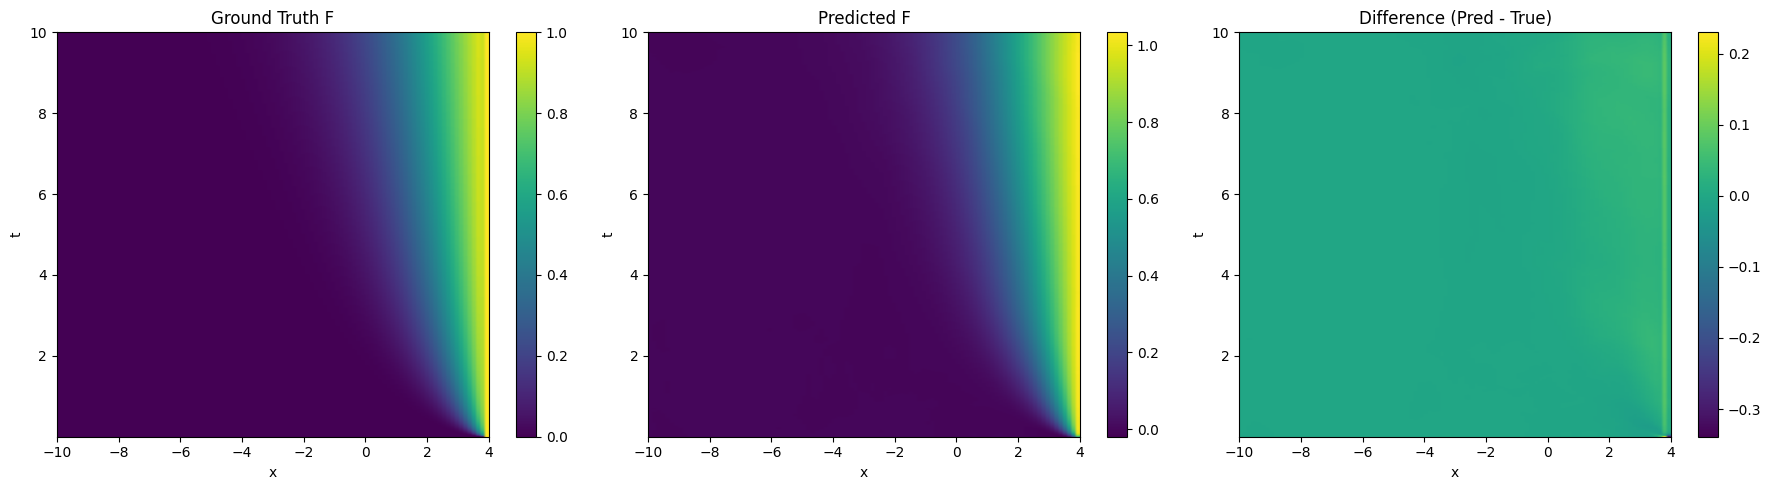

Test Results over 10 cases:
MSE:         Mean = 0.004371, Std = 0.006759
MAE:         Mean = 0.027108, Std = 0.021057
Relative Err: Mean = 0.159754, Std = 0.113468


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure the following are defined in your environment:
# - model: your trained FNO2d instance.
# - ground_truth: function that computes the recovery probability.
# - T_vals, x_vals, T, a

# Lists to store error metrics for each test case
mse_list = []
mae_list = []
rel_error_list = []

num_tests = 10  # Number of test cases

for i in range(num_tests):
    # Generate a test sample (similar to training data)
    if np.random.rand() < 0.5:
        # Single sine wave sample
        A = np.random.uniform(-1, 1)
        freq = np.random.uniform(0.5, 2)
        phi = np.random.uniform(0, 2*np.pi)
        u_test = A * np.sin(2*np.pi * freq * T_vals/T + phi)
    else:
        # Sum of two sine waves sample
        A1 = np.random.uniform(-1, 1)
        freq1 = np.random.uniform(0.5, 2)
        phi1 = np.random.uniform(0, 2*np.pi)
        A2 = np.random.uniform(-1, 1)
        freq2 = np.random.uniform(0.5, 2)
        phi2 = np.random.uniform(0, 2*np.pi)
        u_test = A1 * np.sin(2*np.pi * freq1 * T_vals/T + phi1) + \
                 A2 * np.sin(2*np.pi * freq2 * T_vals/T + phi2)

    # Compute the ground truth recovery probability for the test sample
    F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape (Nt, Nx)

    # Prepare the input tensor for the model
    # Channel 0: control function u(t) (broadcast to (Nt, Nx))
    u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1).repeat(1, len(x_vals))
    # Channel 1: time coordinate (Nt, Nx)
    t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, len(x_vals))
    # Channel 2: spatial coordinate (Nt, Nx)
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(len(T_vals), 1)

    # Stack channels to form input of shape (1, 3, Nt, Nx)
    input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)

    # Set the model to evaluation mode and run the network
    model.eval()
    with torch.no_grad():
        F_pred = model(input_tensor).squeeze().cpu().numpy()  # shape (Nt, Nx)

    # Compute error metrics
    mse = np.mean((F_pred - F_true_test)**2)
    mae = np.mean(np.abs(F_pred - F_true_test))
    # Relative error defined as norm(error)/norm(ground truth)
    rel_error = np.linalg.norm(F_pred - F_true_test) / np.linalg.norm(F_true_test)

    mse_list.append(mse)
    mae_list.append(mae)
    rel_error_list.append(rel_error)

    # Optionally, visualize the first test case
    if i == 0:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Plot ground truth
        im1 = axs[0].imshow(F_true_test, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[0].set_title("Ground Truth F")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        fig.colorbar(im1, ax=axs[0])

        # Plot prediction
        im2 = axs[1].imshow(F_pred, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[1].set_title("Predicted F")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        fig.colorbar(im2, ax=axs[1])

        # Plot difference (error)
        im3 = axs[2].imshow(F_pred - F_true_test, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[2].set_title("Difference (Pred - True)")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("t")
        fig.colorbar(im3, ax=axs[2])

        plt.tight_layout()
        plt.show()

# Report the statistics over the test cases
print(f"Test Results over {num_tests} cases:")
print(f"MSE:         Mean = {np.mean(mse_list):.6f}, Std = {np.std(mse_list):.6f}")
print(f"MAE:         Mean = {np.mean(mae_list):.6f}, Std = {np.std(mae_list):.6f}")
print(f"Relative Err: Mean = {np.mean(rel_error_list):.6f}, Std = {np.std(rel_error_list):.6f}")
